In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


import math
#from pandas_datareader import data as pdr
from datetime import datetime,date
import yfinance as yf
#yf.pdr_override()
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, normalize):

    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize='pred')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    else:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def generate_features(df):

    df['Diff'] = df['Close'].pct_change()
    # df['Diff_Vol'] = df['Volume'].pct_change()
    df['EMA_7'] = df['Close'].ewm(span=7, adjust=False).mean()
    df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['EMA_21'] = df['Close'].ewm(span=21, adjust=False).mean()

    df['MA_7_volume'] = df['Volume'].rolling(window=7).mean()
    df['MA_14_volume'] = df['Volume'].rolling(window=14).mean()
    df['MA_21_volume'] = df['Volume'].rolling(window=21).mean()

    # Calculate new features
    df['Daily_Close'] = (df['Close'] - df['Close']).shift(1) / df['Close'].shift(1)
    df['Daily_Volume'] = (df['Volume'] - df['Volume']).shift(1) / df['Volume'].shift(1)

    df['Close_to_Open'] = (df['Close'] - df['Open']) / df['Close']
    df['Close_to_High'] = (df['Close'] - df['High']) / df['Close']
    df['Close_to_Low'] = (df['Close'] - df['Low']) / df['Close']

    df['Volume_Change_7'] = (df['Volume'] - df['MA_7_volume']) / df['MA_21_volume']
    df['Volume_Change_14'] = (df['Volume'] - df['MA_14_volume']) / df['MA_21_volume']
    df['Volume_Change_21'] = (df['Volume'] - df['MA_21_volume']) / df['MA_21_volume']
    df['EMA_7_Change'] = (df['Close'] - df['EMA_7']) / df['Close']
    df['EMA_14_Change'] = (df['Close'] - df['EMA_14']) / df['Close']
    df['EMA_21_Change'] = (df['Close'] - df['EMA_21']) / df['Close']

    # Calculate target variable
    df['Target'] = np.where(df['Close'].shift(-15) > df['Close'] * 1.075, 1, 0)
    df['Target_Close'] = df['Close'].shift(-15)

     # Select relevant features
    features = ['Open','High','Low' ,'Close', 'Volume', 'Diff',
              'EMA_7', 'EMA_14', 'EMA_21', 'MA_7_volume','MA_14_volume' ,'MA_21_volume',
              'Daily_Close', 'Daily_Volume', 'Close_to_Open', 'Close_to_High', 'Close_to_Low',
    'Volume_Change_7', 'Volume_Change_14', 'Volume_Change_21',
    'EMA_7_Change', 'EMA_14_Change', 'EMA_21_Change']

  # Add last close price and volume of the last 21 days
    for i in range(1, 22):

      df[f'Open_{i}'] = df['Open'].shift(i)
      df[f'High_{i}'] = df['High'].shift(i)
      df[f'Low_{i}'] = df['Low'].shift(i)
      df[f'Close_{i}'] = df['Close'].shift(i)
      df[f'Volume_{i}'] = df['Volume'].shift(i)
      df[f'Diff_{i}'] = df['Diff'].shift(i)
      #df[f'Diff_Vol_{i}'] = df['Diff_Vol'].shift(i)

      df[f'EMA_7_{i}'] = df['EMA_7'].shift(i)
      df[f'EMA_14_{i}'] = df['EMA_14'].shift(i)
      df[f'EMA_21_{i}'] = df['EMA_21'].shift(i)
      df[f'MA_7_volume_{i}'] = df['MA_7_volume'].shift(i)
      df[f'MA_14_volume_{i}'] = df['MA_14_volume'].shift(i)
      df[f'MA_21_volume_{i}'] = df['MA_21_volume'].shift(i)

      df[f'Daily_Close_{i}'] = df['Daily_Close'].shift(i)
      df[f'Daily_Volume_{i}'] = df['Daily_Volume'].shift(i)
      df[f'Close_to_Open_{i}'] = df['Close_to_Open'].shift(i)
      df[f'Close_to_High_{i}'] = df['Close_to_High'].shift(i)
      df[f'Close_to_Low_{i}'] = df['Close_to_Low'].shift(i)
      df[f'Volume_Change_7_{i}'] = df['Volume_Change_7'].shift(i)
      df[f'Volume_Change_14_{i}'] = df['Volume_Change_14'].shift(i)
      df[f'Volume_Change_21_{i}'] = df['Volume_Change_21'].shift(i)
      df[f'EMA_7_Change_{i}'] = df['EMA_7_Change'].shift(i)
      df[f'EMA_14_Change_{i}'] = df['EMA_14_Change'].shift(i)
      df[f'EMA_21_Change_{i}'] = df['EMA_21_Change'].shift(i)


      features.extend([f'Open_{i}',f'High_{i}',f'Low_{i}',f'Close_{i}', f'Volume_{i}',f'Diff_{i}',
                       #f'EMA_7_{i}',f'EMA_14_{i}',f'EMA_21_{i}',
                       # f'MA_7_volume_{i}',f'MA_14_volume_{i}',f'MA_21_volume_{i}',
                     # f'Daily_Close_{i}', f'Daily_Volume_{i}',
                      f'Close_to_Open_{i}',f'Close_to_High_{i}',f'Close_to_Low_{i}',
                      #f'Volume_Change_7_{i}',
                      # f'Volume_Change_14_{i}',f'Volume_Change_21_{i}',
                       #f'EMA_7_Change_{i}',
                       #f'EMA_14_Change_{i}',
                       #f'EMA_21_Change_{i}'
                       ])
    return df,features

In [4]:
def logistic_prediction_val(symbol,plot_confusion=False,save_model=True):

  df = yf.download(symbol + '.NS',"2018-01-01", "2024-06-30")

  df_features, features = generate_features(df)

  X = df[features].dropna()

  # Select the target variable
  y = df['Target']
  y_close = df['Target_Close']
  # Calculate number of validation days
  validation_days = 21

  # Separate validation data
  X_val = X[-validation_days:]
  y_val = y[-validation_days:]
  y_close_val = y_close[-validation_days:]
  merged_df = pd.concat([X_val[['Close']], y_val], axis=1)
  merged_df.columns = ['Close', 'Target']
  merged_df['Target_Close'] = y_close
  merged_df['Symbol'] = symbol
  merged_df =  merged_df[['Symbol','Close', 'Target_Close','Target']]

  # Remove validation data from X and y
  X = X[:-validation_days]
  y = y[:-validation_days].dropna()
  # Ensure that y corresponds to the same samples as X
  y = y.head(len(X))



  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  scaler = StandardScaler()

  scaled_X_train = scaler.fit_transform(X_train)
  scaled_X_test = scaler.transform(X_test)
  scaled_X_val = scaler.transform(X_val)

  # Initialize the logistic regression model
  model = LogisticRegression(class_weight='balanced')
  #model = RandomForestClassifier( n_estimators=100,  max_depth=3, random_state=42, class_weight='balanced',)

  # Train the model
  model.fit(scaled_X_train, y_train)

  # Make predictions on the test set
  y_train_pred = model.predict(scaled_X_train)
  y_test_pred = model.predict(scaled_X_test)


  # Evaluate the model
  accuracy = accuracy_score(y_test, y_test_pred)
  #print(f'Accuracy: {accuracy}')
  #print(confusion_matrix(y_test,predictions))
  #print(classification_report(y_test, predictions))


  # Assuming y_test and predictions are available
  precision = precision_score(y_test, y_test_pred)
  recall = recall_score(y_test, y_test_pred)
  f1 = f1_score(y_test, y_test_pred)
  roc_auc = roc_auc_score(y_test, y_test_pred)
  if plot_confusion:
    plot_confusion_matrix(y_test, y_test_pred, title='Testing Data', normalize=False)
    plot_confusion_matrix(y_test, y_test_pred, title='Testing Data - Normalized', normalize=True)

  validations = model.predict(scaled_X_val)
  merged_df['Predictions'] = validations
  # Reset the index and drop the old 'Date' column if it exists
  merged_df = merged_df.reset_index(drop=False)

  if save_model:
    import os
    os.makedirs("models", exist_ok=True)  # Create the "models" folder if it doesn't exist
    joblib.dump(model, os.path.join("models", f"{symbol}_model.h5"))


  return symbol,round(accuracy,2),round(precision,2),round(recall,2),round(roc_auc,2),merged_df


[*********************100%%**********************]  1 of 1 completed


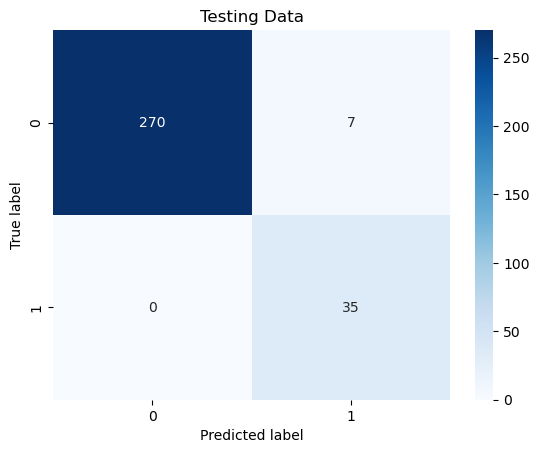

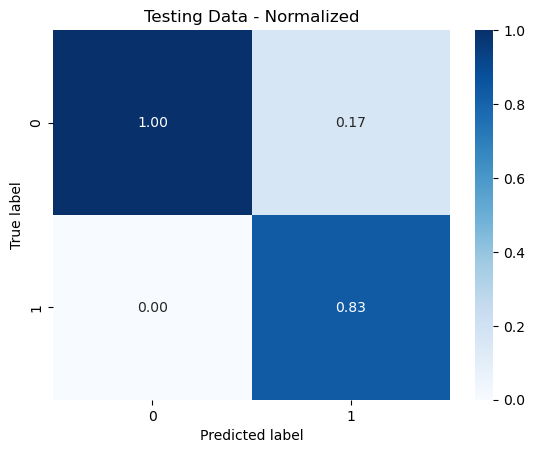

('TCS', 0.98, 0.83, 1.0, 0.99)
         Date Symbol        Close  Target_Close  Target  Predictions
0  2024-05-30    TCS  3736.100098   3810.750000       0            0
1  2024-05-31    TCS  3670.949951   3816.800049       0            0
2  2024-06-03    TCS  3702.850098   3838.449951       0            0
3  2024-06-04    TCS  3715.000000   3855.850098       0            0
4  2024-06-05    TCS  3746.449951   3934.149902       0            0
5  2024-06-06    TCS  3830.399902   3904.149902       0            0
6  2024-06-07    TCS  3893.949951           NaN       0            0
7  2024-06-10    TCS  3858.699951           NaN       0            0
8  2024-06-11    TCS  3852.100098           NaN       0            0
9  2024-06-12    TCS  3831.649902           NaN       0            0
10 2024-06-13    TCS  3878.149902           NaN       0            0
11 2024-06-14    TCS  3832.050049           NaN       0            0
12 2024-06-18    TCS  3815.100098           NaN       0            0
13 

In [5]:
ms = logistic_prediction_val('TCS',plot_confusion=True)

print_msg = []
df_result = pd.DataFrame()
msg =ms[0:5]
df_pred = ms[5]
print_msg.append(msg)
print(msg)
print(df_pred)

In [6]:
df_stocks = pd.read_csv('MarketCap.csv')
print_msg = []
df_result = pd.DataFrame()

stock_symbols = df_stocks['symbol']
for i in stock_symbols:
  try:
    ms = logistic_prediction_val(i)
    msg =ms[0:5]
    df_pred = ms[5]
    print_msg.append(msg)
    print(msg)
    df_result= pd.concat([df_result,df_pred],ignore_index=True)

  except :
    print(i)

[*********************100%%**********************]  1 of 1 completed
('RELIANCE', 0.97, 0.89, 0.96, 0.97)
[*********************100%%**********************]  1 of 1 completed
('TCS', 0.98, 0.83, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('HDFCBANK', 0.97, 0.88, 0.88, 0.93)
[*********************100%%**********************]  1 of 1 completed
('ICICIBANK', 0.94, 0.82, 0.9, 0.93)
[*********************100%%**********************]  1 of 1 completed
('INFY', 0.96, 0.76, 0.97, 0.97)
[*********************100%%**********************]  1 of 1 completed
('SBIN', 0.97, 0.92, 0.97, 0.97)
[*********************100%%**********************]  1 of 1 completed
('BHARTIARTL', 0.96, 0.84, 0.88, 0.93)
[*********************100%%**********************]  1 of 1 completed
('LICI', 0.94, 0.81, 0.81, 0.89)
[*********************100%%**********************]  1 of 1 completed
('HINDUNILVR', 0.97, 0.88, 0.88, 0.93)
[*********************100%%**********************]  1 of 1 c

[*********************100%%**********************]  1 of 1 completed
('BAJAJHLDNG', 0.96, 0.87, 0.95, 0.96)
[*********************100%%**********************]  1 of 1 completed
('IDBI', 0.96, 0.89, 0.98, 0.97)
[*********************100%%**********************]  1 of 1 completed
('DABUR', 0.96, 0.77, 0.77, 0.87)
[*********************100%%**********************]  1 of 1 completed
('HEROMOTOCO', 0.96, 0.78, 0.93, 0.94)
[*********************100%%**********************]  1 of 1 completed
('APOLLOHOSP', 0.97, 0.91, 0.95, 0.96)
[*********************100%%**********************]  1 of 1 completed
('SHREECEM', 0.95, 0.82, 0.93, 0.94)
[*********************100%%**********************]  1 of 1 completed
('ABB', 0.96, 0.92, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 completed
('CHOLAFIN', 0.96, 0.88, 0.99, 0.97)
[*********************100%%**********************]  1 of 1 completed
('NHPC', 0.96, 0.83, 0.93, 0.95)
[*********************100%%**********************]  1 of


1 Failed download:
['MCDOWELL-N.NS']: Exception('%ticker%: No data found, symbol may be delisted')



MCDOWELL-N
[*********************100%%**********************]  1 of 1 completed
('BOSCHLTD', 0.95, 0.84, 0.89, 0.92)
[*********************100%%**********************]  1 of 1 completed
('HINDPETRO', 0.96, 0.89, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('ICICIGI', 0.95, 0.84, 0.88, 0.92)
[*********************100%%**********************]  1 of 1 completed
('HDFCAMC', 0.95, 0.86, 0.92, 0.94)
[*********************100%%**********************]  1 of 1 completed
('JSWENERGY', 0.95, 0.91, 0.91, 0.94)
[*********************100%%**********************]  1 of 1 completed
('BHEL', 0.96, 0.93, 0.95, 0.96)
[*********************100%%**********************]  1 of 1 completed
('JINDALSTEL', 0.96, 0.93, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('IDEA', 0.96, 0.83, 0.97, 0.96)
[*********************100%%**********************]  1 of 1 completed
('MOTHERSON', 0.98, 0.93, 0.97, 0.98)
[*********************100%%************

[*********************100%%**********************]  1 of 1 completed
('MAZDOCK', 0.93, 0.92, 0.86, 0.91)
[*********************100%%**********************]  1 of 1 completed
('MRPL', 0.96, 0.93, 0.88, 0.93)
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['L&TFH.NS']: Exception('%ticker%: No data found, symbol may be delisted')



L&TFH
[*********************100%%**********************]  1 of 1 completed
('POLICYBZR', 0.83, 0.62, 0.84, 0.83)
[*********************100%%**********************]  1 of 1 completed
('SUNDARMFIN', 0.94, 0.75, 0.9, 0.92)
[*********************100%%**********************]  1 of 1 completed
('PETRONET', 0.98, 0.85, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('THERMAX', 0.97, 0.9, 0.97, 0.97)
[*********************100%%**********************]  1 of 1 completed
('COFORGE', 0.96, 0.95, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('HUDCO', 0.97, 0.92, 0.96, 0.97)
[*********************100%%**********************]  1 of 1 completed
('NIACL', 0.96, 0.84, 0.95, 0.95)
[*********************100%%**********************]  1 of 1 completed
('PAGEIND', 0.96, 0.9, 0.9, 0.94)
[*********************100%%**********************]  1 of 1 completed
('KALYANKJIL', 0.97, 0.94, 0.96, 0.96)
[*********************100%%********************

[*********************100%%**********************]  1 of 1 completed
('AARTIIND', 0.96, 0.91, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('KANSAINER', 0.97, 0.89, 0.86, 0.93)
[*********************100%%**********************]  1 of 1 completed
('NBCC', 0.96, 0.9, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('TATACHEM', 0.96, 0.88, 0.89, 0.93)
[*********************100%%**********************]  1 of 1 completed
('APARINDS', 0.94, 0.9, 0.89, 0.93)
[*********************100%%**********************]  1 of 1 completed
('SUNTV', 0.97, 0.88, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('GRINDWELL', 0.91, 0.72, 0.89, 0.9)
[*********************100%%**********************]  1 of 1 completed
('JBMA', 0.95, 0.93, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('ASTERDM', 0.95, 0.81, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 

[*********************100%%**********************]  1 of 1 completed
('AFFLE', 0.95, 0.9, 0.96, 0.95)
[*********************100%%**********************]  1 of 1 completed
('OLECTRA', 0.93, 0.84, 0.94, 0.93)
[*********************100%%**********************]  1 of 1 completed
('JINDALSAW', 0.95, 0.89, 0.96, 0.95)
[*********************100%%**********************]  1 of 1 completed
('INDIAMART', 0.87, 0.7, 0.82, 0.85)
[*********************100%%**********************]  1 of 1 completed
('CENTURYTEX', 0.96, 0.9, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('NATCOPHARM', 0.97, 0.85, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('HSCL', 0.97, 0.91, 0.97, 0.97)
[*********************100%%**********************]  1 of 1 completed
('J&KBANK', 0.97, 0.91, 0.99, 0.98)
[*********************100%%**********************]  1 of 1 completed
('MANAPPURAM', 0.96, 0.9, 0.94, 0.95)
[*********************100%%**********************]  


1 Failed download:
['AEGISCHEM.NS']: Exception('%ticker%: No data found, symbol may be delisted')



AEGISCHEM
[*********************100%%**********************]  1 of 1 completed
('KARURVYSYA', 0.98, 0.94, 0.99, 0.98)
[*********************100%%**********************]  1 of 1 completed
('BLS', 0.95, 0.87, 0.98, 0.96)
[*********************100%%**********************]  1 of 1 completed
('ANANDRATHI', 0.88, 0.79, 0.79, 0.85)
[*********************100%%**********************]  1 of 1 completed
('MGL', 0.98, 0.92, 0.96, 0.97)
[*********************100%%**********************]  1 of 1 completed
('WELSPUNLIV', 0.95, 0.82, 0.95, 0.95)
[*********************100%%**********************]  1 of 1 completed
('NUVAMA', 0.93, 1.0, 0.88, 0.94)
[*********************100%%**********************]  1 of 1 completed
('CLEAN', 0.96, 0.79, 0.95, 0.95)
[*********************100%%**********************]  1 of 1 completed
('ARE&M', 0.8, 0.64, 1.0, 0.84)
[*********************100%%**********************]  1 of 1 completed
('WELCORP', 0.96, 0.91, 0.97, 0.96)
[*********************100%%**********************] 

[*********************100%%**********************]  1 of 1 completed
('ELECON', 0.96, 0.94, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('AETHER', 0.94, 0.73, 0.73, 0.85)
[*********************100%%**********************]  1 of 1 completed
('RAYMOND', 0.95, 0.86, 0.99, 0.96)
[*********************100%%**********************]  1 of 1 completed
('SPARC', 0.96, 0.9, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('CEATLTD', 0.94, 0.76, 0.91, 0.92)
[*********************100%%**********************]  1 of 1 completed
('ECLERX', 0.95, 0.83, 0.95, 0.95)
[*********************100%%**********************]  1 of 1 completed
('COCHINSHIP', 0.96, 0.9, 0.9, 0.94)
[*********************100%%**********************]  1 of 1 completed
('AAVAS', 0.96, 0.85, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('ALKYLAMINE', 0.95, 0.87, 0.95, 0.95)
[*********************100%%**********************]  1 of 1 

[*********************100%%**********************]  1 of 1 completed
('EMIL', 0.88, 0.8, 0.83, 0.87)
[*********************100%%**********************]  1 of 1 completed
('ESABINDIA', 0.96, 0.91, 0.9, 0.94)
[*********************100%%**********************]  1 of 1 completed
('HOMEFIRST', 0.99, 0.92, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('JLHL', 0.86, 0.5, 1.0, 0.92)
[*********************100%%**********************]  1 of 1 completed
('MHRIL', 0.95, 0.85, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('RESPONIND', 0.96, 0.92, 0.92, 0.95)
[*********************100%%**********************]  1 of 1 completed
('MANINFRA', 0.96, 0.9, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('TVSSCS', 0.94, 1.0, 0.33, 0.67)
[*********************100%%**********************]  1 of 1 completed
('SHOPERSTOP', 0.96, 0.85, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 co


1 Failed download:
['UJJIVAN.NS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 -> 2024-06-30)')



UJJIVAN
[*********************100%%**********************]  1 of 1 completed
('SHAREINDIA', 0.96, 0.93, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 completed
('SUNTECK', 0.96, 0.91, 0.95, 0.96)
[*********************100%%**********************]  1 of 1 completed
('TCI', 0.97, 0.87, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('AHLUCONT', 0.76, 0.2, 0.35, 0.58)
[*********************100%%**********************]  1 of 1 completed
('MSTCLTD', 0.96, 0.93, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('GREENLAM', 0.96, 0.89, 0.91, 0.94)
[*********************100%%**********************]  1 of 1 completed
('PRINCEPIPE', 0.94, 0.86, 0.89, 0.93)
[*********************100%%**********************]  1 of 1 completed
('HCC', 0.96, 0.92, 0.95, 0.96)
[*********************100%%**********************]  1 of 1 completed
('DBL', 0.97, 0.92, 0.95, 0.96)
[*********************100%%**********************] 

[*********************100%%**********************]  1 of 1 completed
('GOKEX', 0.96, 0.89, 0.98, 0.96)
[*********************100%%**********************]  1 of 1 completed
('SUPRAJIT', 0.95, 0.85, 0.92, 0.94)
[*********************100%%**********************]  1 of 1 completed
('DBCORP', 0.96, 0.91, 0.92, 0.95)
[*********************100%%**********************]  1 of 1 completed
('TEAMLEASE', 0.95, 0.86, 0.95, 0.95)
[*********************100%%**********************]  1 of 1 completed
('AURIONPRO', 0.96, 0.91, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('NFL', 0.96, 0.9, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('VRLLOG', 0.96, 0.92, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 completed
('KESORAMIND', 0.96, 0.9, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('GALLANTT', 0.95, 0.89, 0.92, 0.94)
[*********************100%%**********************]  1 of

[*********************100%%**********************]  1 of 1 completed
('SUNDARMHLD', 0.97, 0.95, 0.95, 0.96)
[*********************100%%**********************]  1 of 1 completed
('VMART', 0.97, 0.9, 0.97, 0.97)
[*********************100%%**********************]  1 of 1 completed
('LAOPALA', 0.96, 0.81, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('SUNFLAG', 0.96, 0.92, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 completed
('KSCL', 0.97, 0.9, 0.98, 0.98)
[*********************100%%**********************]  1 of 1 completed
('UNICHEMLAB', 0.98, 0.89, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('HMAAGRO', 0.92, 0.75, 0.86, 0.9)
[*********************100%%**********************]  1 of 1 completed
('JTEKTINDIA', 0.97, 0.95, 0.95, 0.97)
[*********************100%%**********************]  1 of 1 completed
('IMAGICAA', 0.77, 0.63, 0.7, 0.75)
[*********************100%%**********************]  1 o

[*********************100%%**********************]  1 of 1 completed
INNOVACAP
[*********************100%%**********************]  1 of 1 completed
('VINDHYATEL', 0.94, 0.89, 0.88, 0.92)
[*********************100%%**********************]  1 of 1 completed
('SUNCLAY', 0.94, 1.0, 0.8, 0.9)
[*********************100%%**********************]  1 of 1 completed
('AXISCADES', 0.97, 0.93, 1.0, 0.98)
[*********************100%%**********************]  1 of 1 completed
('JCHAC', 0.88, 0.58, 0.85, 0.87)
[*********************100%%**********************]  1 of 1 completed
('IDEAFORGE', 0.95, 0.0, 0.0, 0.5)
[*********************100%%**********************]  1 of 1 completed
('SUPRIYA', 0.93, 0.78, 0.96, 0.94)
[*********************100%%**********************]  1 of 1 completed
('NILKAMAL', 0.96, 0.84, 0.98, 0.97)
[*********************100%%**********************]  1 of 1 completed
('GIPCL', 0.97, 0.91, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('MOLDTKPAC', 0


1 Failed download:
['ISMTLTD.NS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 -> 2024-06-30)')



ISMTLTD
[*********************100%%**********************]  1 of 1 completed
('SWARAJENG', 0.95, 0.74, 0.9, 0.93)
[*********************100%%**********************]  1 of 1 completed
('TATVA', 0.95, 0.78, 0.82, 0.89)
[*********************100%%**********************]  1 of 1 completed
('PARACABLES', 0.97, 0.91, 0.98, 0.97)
[*********************100%%**********************]  1 of 1 completed
('MAHLOG', 0.96, 0.83, 0.98, 0.97)
[*********************100%%**********************]  1 of 1 completed
('KCP', 0.97, 0.95, 0.95, 0.97)
[*********************100%%**********************]  1 of 1 completed
('PARAS', 0.94, 0.85, 0.81, 0.89)
[*********************100%%**********************]  1 of 1 completed
('GTLINFRA', 0.96, 0.9, 0.96, 0.96)
[*********************100%%**********************]  1 of 1 completed
('SOTL', 0.96, 0.9, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('DIAMONDYD', 0.96, 0.81, 0.96, 0.96)
[*********************100%%**********************]  1

[*********************100%%**********************]  1 of 1 completed
('DPSCLTD', 0.98, 0.94, 0.98, 0.98)
[*********************100%%**********************]  1 of 1 completed
('63MOONS', 0.93, 0.81, 0.94, 0.93)
[*********************100%%**********************]  1 of 1 completed
('SUVEN', 0.96, 0.94, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 completed
('BHARATWIRE', 0.96, 0.92, 0.95, 0.95)
[*********************100%%**********************]  1 of 1 completed
('FOSECOIND', 0.97, 0.91, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 completed
('MONARCH', 0.93, 0.84, 0.94, 0.93)
[*********************100%%**********************]  1 of 1 completed
('TIRUMALCHM', 0.98, 1.0, 0.95, 0.97)
[*********************100%%**********************]  1 of 1 completed
('IKIO', 0.95, 0.0, 0.0, 0.49)
[*********************100%%**********************]  1 of 1 completed
('ARMANFIN', 0.96, 0.94, 0.95, 0.96)
[*********************100%%**********************]  1 

In [7]:
df_result.to_csv('model_result.csv')

In [8]:
columns = ['Symbol','Accuracy','Precision','Recall','ROC Score']
df_model_result = pd.DataFrame(print_msg, columns=columns)
df_model_result.to_csv('model_details.csv')
df_model_result



,Symbol,Accuracy,Precision,Recall,ROC Score
0,RELIANCE,0.97,0.89,0.96,0.97
1,TCS,0.98,0.83,1.00,0.99
2,HDFCBANK,0.97,0.88,0.88,0.93
3,ICICIBANK,0.94,0.82,0.90,0.93
4,INFY,0.96,0.76,0.97,0.97
...,...,...,...,...,...
956,NITINSPIN,0.94,0.88,0.90,0.93
957,SIRCA,0.51,0.24,0.38,0.47
958,PANAMAPET,0.96,0.90,0.94,0.95
959,GENESYS,0.95,0.91,0.94,0.95
